In [1]:
import torch as T
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import scipy.linalg
from functools import partial
%pylab
%matplotlib inline
import matplotlib as mpl
import matplotlib.gridspec as gridspec
import scipy.sparse as sparse
from scipy import stats
from __future__ import print_function
import gc
from tqdm import tqdm
from __future__ import division
import pandas as pd
import seaborn as sb
import os
from tqdm import tqdm
from pandas import DataFrame
from scipy.spatial import distance
from scipy.cluster import hierarchy
from torchvision.transforms import Resize
import dill
from joblib import Parallel, delayed
import cv2

import os, sys, datetime
LF_CODE_PATH = os.path.expanduser('~/projects/LFAnalyze/code')
FT_CODE_PATH = os.path.expanduser('~/projects/fishTrax/code/analysis/')
FD_CODE_PATH = os.path.expanduser('~/projects/fish_despair_notebooks/src/')
sys.path.insert(0,LF_CODE_PATH)
sys.path.insert(0,FT_CODE_PATH)
sys.path.insert(0,FD_CODE_PATH)

import passivity_2p_imaging_utils as p2putils
reload(p2putils)
tmp_dir = '/tmp/'
all_data = p2putils.get_all_datasets(tmp_dir=tmp_dir)

f = all_data['e'][2]

time_fish = T.from_numpy(f.frame_st.mean(1).astype(np.float32)).cuda()
u_fish = T.cuda.FloatTensor(time_fish.shape).zero_()
p_fish = T.cuda.FloatTensor(time_fish.shape).zero_()
u_fish[numpy.searchsorted(f.frame_et[:,-1], f.shock_st,side="left")] = 1

/home/ubuntu/anaconda3/envs/pytorch_p27/lib/python2.7/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/pytorch_p27/lib/python2.7/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


Using matplotlib backend: agg
Populating the interactive namespace from numpy and matplotlib


/home/ubuntu/anaconda3/envs/pytorch_p27/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [4]:
def get_frames_from_z(z, fish):
    tiff = fish.get_tif_rasl(z)
    ntime = fish.frame_et.shape[0]
    frames = np.zeros((ntime, tiff.frame_shape[0],tiff.frame_shape[1])).astype(np.float32)
    for t in range(ntime):
        frame = np.array(tiff.get_frame(t)).astype(np.float32)
        frames[t] = frame
    return frames

def get_imaging_from_fish(f,n_jobs=8):
    nZ = f.num_zplanes
    # frames_by_z = pool.map(partial(get_frames_from_z, fish=f), range(nZ))
    frames_by_z = Parallel(n_jobs=n_jobs)(delayed(get_frames_from_z)(z,fish=f) for z in range(nZ))
    imaging = np.stack(frames_by_z).swapaxes(0,1).astype(np.float32)
    return imaging

In [6]:
def resize_volume(images, fx, fy, interpolation=cv2.INTER_CUBIC):
    im = cv2.resize(images[0], None, fx=fx, fy=fy, interpolation=interpolation)
    new = np.zeros([images.shape[0],im.shape[0],im.shape[1]]).astype(np.float32)
    new[0] = im
    for i, img in enumerate(images[1:]):
        new[i] = cv2.resize(img, None, fx=fx, fy=fy, interpolation=interpolation)
    return new

def resize_batch(images, fx, fy, interpolation=cv2.INTER_CUBIC):
    im = cv2.resize(images[0,0], None, fx=fx, fy=fy, interpolation=interpolation)
    new = np.zeros([images.shape[0],images.shape[1], im.shape[0],im.shape[1]]).astype(np.float32)
    for b, vol in enumerate(images):
        for z, img in enumerate(vol):
            new[b,z] = cv2.resize(img, None, fx=fx, fy=fy, interpolation=interpolation)
    return new

In [8]:
imaging = get_imaging_from_fish(f)

In [9]:
class FishImageData(Dataset):    
    def __init__(self, imaging):
        self.data = T.from_numpy(imaging)
        
    def __len__(self):
        return self.data.shape[0]-1

    def __getitem__(self, idx):
        return self.data[idx], self.data[idx+1]

data = FishImageData(imaging)
batch_size = 64
nZ, H, W = data[0][0].shape

In [88]:
nZ, H,W

(11, 232, 512)

In [89]:
from sympy import factorint

In [90]:
factorint(H)

{2: 3, 29: 1}

In [91]:
factorint(W)

{2: 9}

In [58]:
512/25

20.48

In [136]:
T.cuda.empty_cache()

In [60]:
21**2*320


141120

In [ ]:
def plot_model_vs_real(model,data):
    plt.figure(figsize=(15,15))

    with T.no_grad():
        for i in range(4):
            time = np.random.randint(len(data))
            z = np.random.randint(nZ)
            X, Y = data[time]
            X_pred = model(X[None,:,None].cuda())
            plt.subplot(4,2,i*2+1)
            plt.imshow(X_pred[0,0].cpu().numpy())
            plt.title("Time="+str(time) + ", z="+str(z))
            plt.subplot(4,2,i*2+2)
            plt.imshow(X[0].cpu().numpy())

In [116]:
def get_padding(padding_type, kernel_size):
    assert padding_type in ['SAME', 'VALID']
    if padding_type == 'SAME':
        return tuple((k - 1) // 2 for k in kernel_size)
    return tuple(0 for _ in kernel_size)

class Conv(nn.Module):
    def __init__(self, nZ=11, H=232, W=512, nEmbedding=20):
        super(Conv, self).__init__()
        self.nZ = nZ
        self.H = H
        self.W = W
        # batch x channel x Z x H x W
        # Encoding
        self.conv1 = nn.Parameter(T.cuda.FloatTensor(8,1,9,9))
#         self.conv1 = nn.Conv2d(1,1,1,9,9)
        self.pad1 = get_padding('SAME',(9,9))
        self.activation = nn.ReLU()
        self.conv2 = nn.Parameter(T.cuda.FloatTensor(16,8,9,9))
        self.pad2 = get_padding('SAME',(9,9))
        # b x 11 x 32 x 11 x 25
        self.encoding = nn.Linear(nZ*12*26, nEmbedding, bias=False)
        
        # Decoding (super resolution)
        # https://arxiv.org/pdf/1609.05158.pdf
        upscale_factor = 22
        self.dconv1 = nn.Parameter(T.cuda.FloatTensor(64,16,5,5))
        self.dpad1 = (2,2)
        self.dconv2 = nn.Parameter(T.cuda.FloatTensor(64,64,3,3))
        self.dpad2 = (1,1)
        self.dconv3 = nn.Parameter(T.cuda.FloatTensor(32,64,3,3))
        self.dpad3 = (1,1)
        self.dconv4 = nn.Parameter(T.cuda.FloatTensor(upscale_factor**2,32,3,3))
        self.dpad4 = (1,1)
        self.pixel_shuffle = nn.PixelShuffle(upscale_factor)
        
        self._initialize_weights()
                
    def vol_conv(self, x, weight, pad):
        # batch x Z x C x H x W
        activations = T.cuda.FloatTensor(x.shape[0],x.shape[1],weight.shape[0],x.shape[3],x.shape[4])
        for z in range(x.shape[1]):
            activations[:,z] = F.conv2d(x[:,z], weight, padding=pad)
        return activations
    
    def vol_MaxPool2d(self, x, kernel_size):
        # batch x Z*C x H x W
        input = x.view(x.shape[0],-1,x.shape[3],x.shape[4])
        pooled = F.max_pool2d(input,kernel_size)
        return pooled.reshape(pooled.shape[0],x.shape[1],x.shape[2],pooled.shape[2],pooled.shape[3])
    
    def vol_PixelShuffle(self, x):
        first = self.pixel_shuffle(x[:,0])
        # b x z x H x W
        ret = T.cuda.FloatTensor(x.shape[0],x.shape[1],first.shape[2], first.shape[3])
        for z in range(x.shape[1]):
            ret[:,z] = self.pixel_shuffle(x[:,z])[:,0]
        return ret
        
        # batch x Z*C x H x W
        input = x.view(x.shape[0],-1,x.shape[3],x.shape[4])
        pooled = F.max_pool2d(input,kernel_size)
        return pooled.reshape(pooled.shape[0],x.shape[1],x.shape[2],pooled.shape[2],pooled.shape[3])
    
    def encode(self, x):
        # b x 11 x 1 x 232 x 512
        x = self.activation(self.vol_MaxPool2d(self.vol_conv(x, self.conv1, self.pad1),4))
        # b x 11 x 8 x 58 x 128
        x = self.activation(self.vol_MaxPool2d(self.vol_conv(x, self.conv2, self.pad2),5))
        # b x 11 x 32 x 11 x 25
        return x
    
    def crop(self, x):
        cropH = (x.shape[2] - self.H)/2
        cropW = (x.shape[3] - self.W)/2
        x = x[:,:,int(np.floor(cropH)):-int(np.ceil(cropH))]
        x = x[:,:,:,int(np.floor(cropW)):-int(np.ceil(cropW))]
        return x

    def decode(self, x):
        x = self.activation(self.vol_conv(x, self.dconv1, self.dpad1))
        x = self.activation(self.vol_conv(x, self.dconv2, self.dpad2))
        x = self.activation(self.vol_conv(x, self.dconv3, self.dpad3))
        x = self.vol_PixelShuffle(self.vol_conv(x, self.dconv4, self.dpad4))
        return self.crop(x)

    def forward(self, x):
        encoded = self.encode(x)
        decoded = self.decode(encoded)
        return decoded
    
    def _initialize_weights(self):
        nn.init.orthogonal_(self.conv1, nn.init.calculate_gain('relu'))
        nn.init.orthogonal_(self.conv2, nn.init.calculate_gain('relu'))
        nn.init.orthogonal_(self.dconv1, nn.init.calculate_gain('relu'))
        nn.init.orthogonal_(self.dconv2, nn.init.calculate_gain('relu'))
        nn.init.orthogonal_(self.dconv3, nn.init.calculate_gain('relu'))
        nn.init.orthogonal_(self.dconv4, nn.init.calculate_gain('relu'))


# def train(model,data,nepochs=10, lambdaA=(1e-8, 1e-6), lambdaB=(1e-6, 1e-6),
#           lambdaC=(1e-5, 1e-5), lambdaD=(1e-5, 1e-5), lr=0.1, verbose=True):
def train(model,data,nepochs=10, lr=0.1):
    dataloader = DataLoader(data, batch_size=batch_size, shuffle=True)
    optimizer = T.optim.Adam(model.parameters(),lr=lr)
    
    for e in range(nepochs):
        print("epoch {}: ".format(e), end="")
        cum_loss = 0
        for batch_data in dataloader:
            X, _ = batch_data
            # add 1 channel
            X_pred = model(X[:,:,None].cuda())
            loss = F.mse_loss(X_pred,X.cuda())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            cum_loss += float(loss)

        print("avg_loss: {:3E}".format(cum_loss/len(data)))

nEmbedding = 20
batch_size = 64
nZ, H, W = data[0][0].shape

# conv_model = Conv(nZ,H,W,nEmbedding)
# conv_model.cuda()
# conv_model(data[0][0][None,:,None].cuda()).shape
train(conv_model,data,25,lr=1e-3)
plot_model_vs_real(conv_model,data)

epoch 0: avg_loss: 8.362852E+01
epoch 1: avg_loss: 7.545273E+01
epoch 2: avg_loss: 7.343909E+01
epoch 3: avg_loss: 7.154127E+01
epoch 4: avg_loss: 6.962530E+01
epoch 5: avg_loss: 6.814646E+01
epoch 6: avg_loss: 6.663856E+01
epoch 7: avg_loss: 6.583457E+01
epoch 8: avg_loss: 6.519144E+01
epoch 9: avg_loss: 6.470276E+01
epoch 10: avg_loss: 6.401829E+01
epoch 11: avg_loss: 6.341674E+01
epoch 12: avg_loss: 6.305191E+01
epoch 13: avg_loss: 6.261096E+01
epoch 14: avg_loss: 6.227237E+01
epoch 15: avg_loss: 6.189242E+01
epoch 16: avg_loss: 6.166587E+01
epoch 17: avg_loss: 6.138119E+01
epoch 18: avg_loss: 6.121181E+01
epoch 19: avg_loss: 6.082758E+01
epoch 20: avg_loss: 6.068087E+01
epoch 21: avg_loss: 6.056198E+01
epoch 22: avg_loss: 6.037072E+01
epoch 23: avg_loss: 6.022981E+01
epoch 24: avg_loss: 6.004922E+01


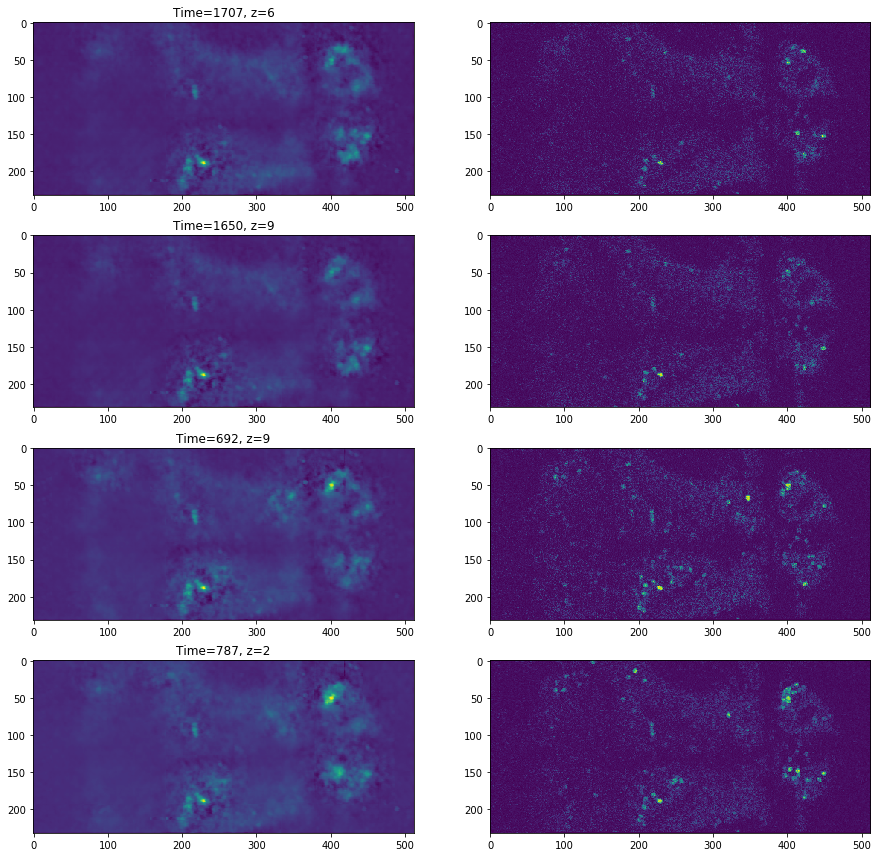

In [118]:
# 6.00E+1
plot_model_vs_real(conv_model,data)

In [83]:
21**2

441

In [79]:
print("total num params:", np.sum([np.prod(x.shape) for x in conv_model.parameters()]))

total num params: 287560


In [37]:
data[0][0].shape

torch.Size([11, 232, 512])

epoch 0: avg_loss: 6.878254E+01
epoch 1: avg_loss: 6.823195E+01
epoch 2: avg_loss: 6.815620E+01


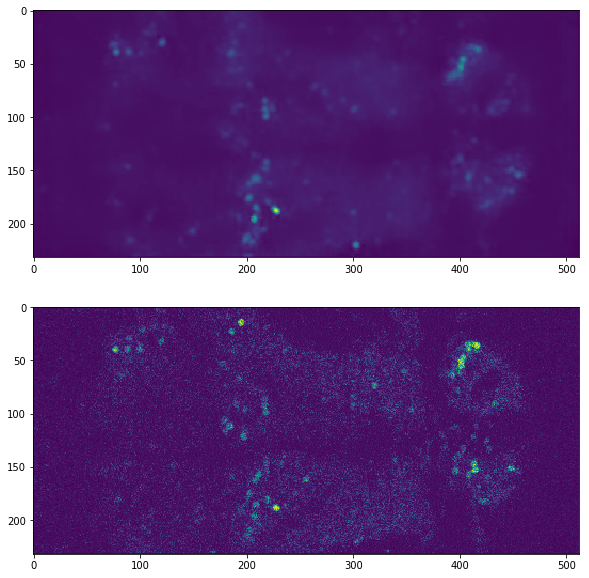

In [12]:
# 2D
class SuperRes(nn.Module):
    def __init__(self, upscale_factor):
        super(SuperRes, self).__init__()

        self.relu = nn.ReLU()
        self.conv1 = nn.Conv2d(1, 64, (5, 5), (1, 1), (2, 2))
        self.conv2 = nn.Conv2d(64, 64, (3, 3), (1, 1), (1, 1))
        self.conv3 = nn.Conv2d(64, 32, (3, 3), (1, 1), (1, 1))
        self.conv4 = nn.Conv2d(32, upscale_factor ** 2, (3, 3), (1, 1), (1, 1))
        self.pixel_shuffle = nn.PixelShuffle(upscale_factor)

        self._initialize_weights()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        x = self.pixel_shuffle(self.conv4(x))
        return x

    def _initialize_weights(self):
        nn.init.orthogonal_(self.conv1.weight, nn.init.calculate_gain('relu'))
        nn.init.orthogonal_(self.conv2.weight, nn.init.calculate_gain('relu'))
        nn.init.orthogonal_(self.conv3.weight, nn.init.calculate_gain('relu'))
        nn.init.orthogonal_(self.conv4.weight)
        
def train(model,data,nepochs=10, lr=0.1, batch_size=32):
    dataloader = DataLoader(data, batch_size=batch_size, shuffle=True)
    optimizer = T.optim.Adam(model.parameters(),lr=lr)
    
    for e in range(nepochs):
        print("epoch {}: ".format(e), end="")
        cum_loss = 0
        for batch_data in dataloader:
            X, _ = batch_data
            X = X.reshape(-1,X.shape[2],X.shape[3])
            x = T.from_numpy(resize_volume(X.numpy(),0.25,0.25)).cuda()[:,None]
            X_pred = model(x)
            loss = F.mse_loss(X_pred[:,0],X.cuda())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            cum_loss += float(loss)

        print("avg_loss: {:3E}".format(cum_loss/len(data)))
    with T.no_grad():
        plt.figure(figsize=(10,10))
        plt.subplot(2,1,1)
        plt.imshow(X_pred[0,0].cpu().numpy())
        plt.subplot(2,1,2)
        plt.imshow(X[0].cpu().numpy())

super_res = SuperRes(4)
super_res.cuda()
batch_size = 64
train(super_res,data,10,lr=1e-3, batch_size=batch_size)

In [22]:
class VAE(nn.Module):
    def __init__(self, nZ, H, W, nHidden=100, nEmbedding=20):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(nZ*H*W, 100)
        self.fc21 = nn.Linear(100, nEmbedding)
        self.fc22 = nn.Linear(100, nEmbedding)
        self.fc3 = nn.Linear(nEmbedding, 100)
        self.fc4 = nn.Linear(100, nZ*H*W)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        if self.training:
            std = torch.exp(0.5*logvar)
            eps = torch.randn_like(std)
            return eps.mul(std).add_(mu)
        else:
            return mu

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return F.sigmoid(self.fc4(h3))
    
    def forward(self, x):
        mu, logvar = self.encode(x.reshape(x.shape[0],-1))
        z = self.reparameterize(mu, logvar)
        return self.decode(z).reshape(x.shape), mu, logvar

    
# Reconstruction + KL divergence losses summed over all elements and batch
def loss_function(recon_x, x, mu, logvar):
    BCE = F.cross_entropy(recon_x, x, size_average=False)

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD

def train(model,data,nepochs=10, lr=0.1):
    dataloader = DataLoader(data, batch_size=batch_size, shuffle=True)
    optimizer = T.optim.Adam(model.parameters(),lr=lr)
    
    for e in range(nepochs):
        print("epoch {}: ".format(e), end="")
        cum_loss = 0
        for batch_data in dataloader:
            X, Y = batch_data
            x = X.cuda()
            recon_batch, mu, logvar = model(x)
            print(recon_batch.dtype,x.dtype)
            loss = loss_function(recon_batch, x, mu, logvar)
            optimizer.zero_grad()
            loss.backward()
            cum_loss += loss.item()
            optimizer.step()
            cum_loss += float(loss)

        print("avg_loss: {:3E}".format(cum_loss/len(data)))
        with torch.no_grad():
            sample = torch.randn(64, 20).to(device)
            sample = model.decode(sample).cpu()
            save_image(sample.view(64, 1, 28, 28),
                       'results/sample_' + str(epoch) + '.png')

# def train(epoch):
#     model.train()
#     train_loss = 0
#     for batch_idx, (data, _) in enumerate(train_loader):
#         data = data.to(device)
#         optimizer.zero_grad()
#         recon_batch, mu, logvar = model(data)
#         loss = loss_function(recon_batch, data, mu, logvar)
#         loss.backward()
#         train_loss += loss.item()
#         optimizer.step()
#         if batch_idx % log_interval == 0:
#             print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
#                 epoch, batch_idx * len(data), len(train_loader.dataset),
#                 100. * batch_idx / len(train_loader),
#                 loss.item() / len(data)))

#     print('====> Epoch: {} Average loss: {:.4f}'.format(
#           epoch, train_loss / len(train_loader.dataset)))


# def test(epoch):
#     model.eval()
#     test_loss = 0
#     with torch.no_grad():
#         for i, (data, _) in enumerate(test_loader):
#             data = data.to(device)
#             recon_batch, mu, logvar = model(data)
#             test_loss += loss_function(recon_batch, data, mu, logvar).item()
#             if i == 0:
#                 n = min(data.size(0), 8)
#                 comparison = torch.cat([data[:n],
#                                       recon_batch.view(batch_size, 1, 28, 28)[:n]])
#                 save_image(comparison.cpu(),
#                          'results/reconstruction_' + str(epoch) + '.png', nrow=n)

#     test_loss /= len(test_loader.dataset)
#     print('====> Test set loss: {:.4f}'.format(test_loss))

model = VAE(nZ,H,W,64,16)
model.cuda()

train(model,data, lr=1e-3)

epoch 0: torch.float32 torch.float32


RuntimeError: Expected object of type torch.cuda.LongTensor but found type torch.cuda.FloatTensor for argument #2 'target'

In [21]:
Y_pred[0].dtype

torch.float32

TypeError: tuple indices must be integers, not tuple

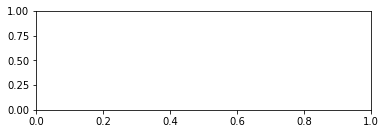

In [8]:
with T.no_grad():
    X, Y = data[0]
    Y_pred = model(X.cuda()[None])
    plt.subplot(2,1,1)
    plt.imshow(Y_pred[0,6].cpu().numpy())
    plt.subplot(2,1,2)
    plt.imshow(Y[6].cpu().numpy())

In [ ]:
class Dense(nn.Module):
    def __init__(self, nZ, H, W, nEmbedding):
        super(Dense, self).__init__()
        self.Dense1 = nn.Linear(nZ*H*W,nEmbedding, bias=False)
        self.Dense2 = nn.Linear(nEmbedding,nZ*H*W, bias=False)

    def forward(self, x):
        encoded = F.relu(self.Dense1(x.reshape(x.shape[0],-1)))
        decoded = self.Dense2(encoded)
        return decoded.reshape(x.shape)

    
class Conv(nn.Module):
    def __init__(self, nZ, H, W, nEmbedding):
        super(Dense, self).__init__()
        self.Dense1 = nn.Conv2d()
        self.Dense2 = nn.Linear(nEmbedding,nZ*H*W, bias=False)

    def forward(self, x):
        encoded = self.Dense1(x.reshape(x.shape[0],-1))
        decoded = self.Dense2(encoded)
        return decoded.reshape(x.shape)

    
# def train(model,data,nepochs=10, lambdaA=(1e-8, 1e-6), lambdaB=(1e-6, 1e-6),
#           lambdaC=(1e-5, 1e-5), lambdaD=(1e-5, 1e-5), lr=0.1, verbose=True):
def train(model,data,nepochs=10, lr=0.1):
    dataloader = DataLoader(data, batch_size=batch_size, shuffle=True)
    optimizer = T.optim.Adam(model.parameters(),lr=lr)
    
    for e in range(nepochs):
        print("epoch {}: ".format(e), end="")
        cum_loss = 0
        for batch_data in dataloader:
            X, Y = batch_data
            Y_pred = model(X.cuda())
            loss = F.mse_loss(Y_pred,X.cuda())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            cum_loss += float(loss)

        print("avg_loss: {:3E}".format(cum_loss/len(data)))

nEmbedding = 20
batch_size = 64
nZ, H, W = data[0][0].shape

dense_model = Dense(nZ,H,W,nEmbedding)
dense_model.cuda()

train(dense_model,data,10,lr=1e-3)

In [63]:
mean_fish = data.data.mean(0)
min_fish = data.data.min(0)[0]

max_fish = data.data.max(0)[0]

var_fish = data.data.var(0)

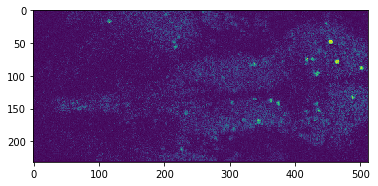

In [27]:
plt.imshow(imaging[0,9])

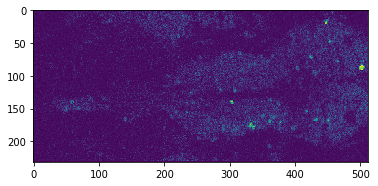

In [26]:
plt.imshow(imaging[0,10])

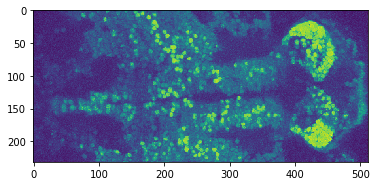

In [61]:
plt.imshow(max_fish[6])

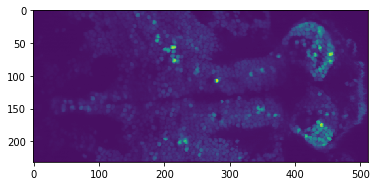

In [62]:
plt.imshow(mean_fish[6])

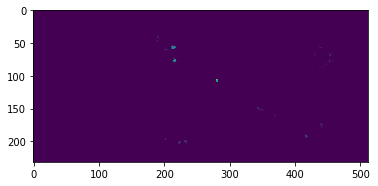

In [56]:
plt.imshow(min_fish[6])

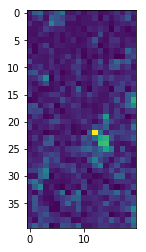

In [16]:
plt.imshow(imaging[0,6,180:220,180:200])

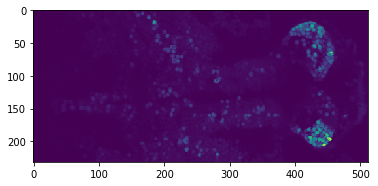

In [64]:
plt.imshow(var_fish[6])

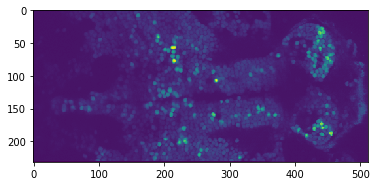

In [57]:
plt.imshow(data.data[0:400].mean(0)[6])

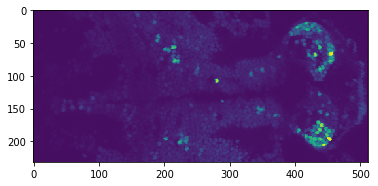

In [58]:
plt.imshow(data.data[2000:2400].mean(0)[6])